## ARMADA pipeline using orbitize

In [30]:
import numpy as np
import orbitize
from orbitize import driver,system,priors,sampler
from orbitize import read_input
import multiprocessing as mp
import os
from astropy.time import Time
from read_data import read_data,read_wds,read_orb6
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import string
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc

%matplotlib inline

### First grab our ARMADA/WDS data to format it for orbitize

In [31]:
## select target, data
target = 'HD_6456'
data_armada = '/Users/tgardner/ARMADA_orbits/HD6456_chi2err/HD_6456_armada.txt'
data_wds = '/Users/tgardner/ARMADA_orbits/HD6456_chi2err/HD_6456_wds.txt'

#data_rv = '/Users/tgardne/ARMADA_orbits/HD45542_rv_paper.dat'

In [32]:
## read in armada data
file=open(data_armada)
weight=1
t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

## read in wds data
file=open(data_wds)
weight=1
t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
file.close()

In [33]:
## read in rv
#file=open(data_rv)
#t_rv = []
#v = []
#verr = []
#for line in file.readlines():
#    if line.startswith('#'):
#        continue 
#    t_rv.append(float(line.split()[0])-2400000.5)
#    if line.split()[7]=='-':
#        v.append(np.nan)
#    else:
#        v.append(float(line.split()[7]))   
#    if line.split()[9]=='O':
#        verr.append(11)
#    else:
#        verr.append(3)
#file.close()

#weight=2

#v=np.asarray(v)
#verr=np.asarray(verr)*weight
#t_rv=np.asarray(t_rv)
#print(t_rv)

#plt.errorbar(t_rv,v,yerr=verr,fmt='o')
#plt.show()

In [34]:
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)

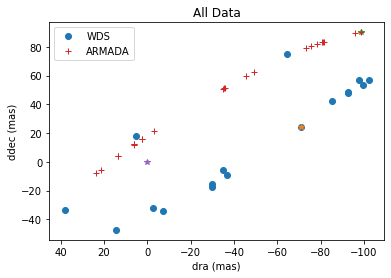

In [35]:
idx = np.argmin(t)
plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [36]:
## convert errors for orbitize
xerr = []
yerr = []
for i,j,k in zip(error_maj,error_min,error_deg):
    xerr1 = abs(i*np.sin(k*np.pi/180))
    xerr2 = abs(j*np.cos(k*np.pi/180))
    yerr1 = abs(i*np.cos(k*np.pi/180))
    yerr2 = abs(j*np.sin(k*np.pi/180))
    xerr.append(max(xerr1,xerr2))
    yerr.append(max(yerr1,yerr2))
xerr = np.array(xerr)
yerr = np.array(yerr)

xerr_wds = []
yerr_wds = []
for i,j,k in zip(error_maj_wds,error_min_wds,error_deg_wds):
    xerr1 = abs(i*np.sin(k*np.pi/180))
    xerr2 = abs(j*np.cos(k*np.pi/180))
    yerr1 = abs(i*np.cos(k*np.pi/180))
    yerr2 = abs(j*np.sin(k*np.pi/180))
    xerr_wds.append(max(xerr1,xerr2))
    yerr_wds.append(max(yerr1,yerr2))
xerr_wds = np.array(xerr_wds)
yerr_wds = np.array(yerr_wds)

print(xerr,yerr)
print(xerr_wds,yerr_wds)

[0.04664785 0.03949527 0.02057234 0.01173751 0.01815925 0.07199153
 0.02142304 0.04743691 0.01958606 0.01987655 0.02772536 0.02668201
 0.02301724 0.16746026 0.0145988  0.02701759 0.02168953 0.01613327
 0.0166239  0.06749772 0.06488758 0.06400935 0.03378778] [0.08065282 0.06194161 0.01693336 0.01223989 0.02087828 0.1034372
 0.02439255 0.02662525 0.01440974 0.01499287 0.01846716 0.01600921
 0.01718884 0.14317578 0.0108878  0.01680085 0.01317845 0.01781588
 0.01466547 0.05679232 0.03740578 0.08477136 0.03014711]
[2.38834899 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899
 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899
 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899] [2.38834899 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899
 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899
 2.38834899 2.38834899 2.38834899 2.38834899 2.38834899]


In [37]:
## need to write to csv file for orbitize
f = open("/Users/tgardner/ARMADA_orbits/%s.csv"%target,"w+")
f.write("epoch object raoff raoff_err decoff decoff_err\r\n")

for i,j,k,l,m in zip(t_wds,xpos_wds,xerr_wds,ypos_wds,yerr_wds):
    f.write("%s 1 %s %s %s %s\r\n"%(i,j,k,l,m))
    
for i,j,k,l,m in zip(t,xpos,xerr,ypos,yerr):
    f.write("%s 1 %s %s %s %s\r\n"%(i,j,k,l,m))
    
#for i,j,k in zip(t_rv,v,verr):
#    f.write("%s 0 %s %s %s %s %s %s\r\n"%(i,np.nan,np.nan,np.nan,np.nan,j,k))

f.close()

### Now initiate an orbitize run

In [38]:
## set up data file
filename = "/Users/tgardner/ARMADA_orbits/%s.csv"%target.format(orbitize.DATADIR)
data_table = read_input.read_file(filename)
data_table.pprint_all()

      epoch        object        quant1            quant1_err             quant2            quant2_err      quant12_corr quant_type instrument
------------------ ------ ------------------- -------------------- ------------------- -------------------- ------------ ---------- ----------
  51183.6455212601      1  -70.95569309098433      2.3883489930089  24.295876563277965      2.3883489930089          nan      radec      defrd
    51502.72110718      1  -85.23940343893204      2.3883489930089   41.94334394603005      2.3883489930089          nan      radec      defrd
 51767.99651704007      1 -102.33153070548309      2.3883489930089  56.720876434279226      2.3883489930089          nan      radec      defrd
 51823.84204942011      1  -99.40150257015871      2.3883489930089  53.743290621199705      2.3883489930089          nan      radec      defrd
 51823.84204942011      1  -97.66433637531638      2.3883489930089   56.83904820076646      2.3883489930089          nan      radec      defrd

In [39]:
## select system parameters
num_secondary_bodies = 1

plx = 11.86 # [mas]
plx_err = 0 # [mas]


mass_total = ((ufloat(115.553,0.122)/1000) / (plx/1000))**3 / (ufloat(5308.6978,6.496)/365.25)**2
system_mass = mass_total.nominal_value
mass_err = mass_total.std_dev
#mass_err=0
print(mass_total)

# MCMC parameters
num_temps = 20
num_walkers = 1000
num_threads = mp.cpu_count() # or a different number if you prefer

4.378+/-0.018


In [40]:
## modify parameters
sys = system.System(
    num_secondary_bodies, data_table, system_mass,
    plx, mass_err=mass_err, plx_err=plx_err,
    tau_ref_epoch=0)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 11.86, Gaussian]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'mtot': 7}


In [41]:
## change mtot to uniform
#sys.sys_priors[lab['mtot']] = priors.UniformPrior(2,5)
#sys.sys_priors[lab['m0']] = 4.5

## limit Omega to <180deg (IF NO RV)
sys.sys_priors[lab['pan1']] = priors.UniformPrior(0,np.pi)

## limit Omega to <180deg (IF NO RV)
sys.sys_priors[lab['aop1']] = priors.UniformPrior(np.pi,2*np.pi)

## I find uniform prior better for semi-major
#sys.sys_priors[lab['sma1']] = priors.UniformPrior(50,200)
#sys.sys_priors[lab['gamma']] = priors.UniformPrior(-50,50)
#sys.sys_priors[lab['sigma']] = priors.UniformPrior(-50,50)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 11.86, Gaussian]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'mtot': 7}


### Now Run the MCMC

In [52]:
## setup a run
my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads})

In [53]:
curr_pos_shape = my_driver.sampler.curr_pos.shape # Get shape of walker positions

## set starting parameters
sma_cen = 115.553 / plx
sma_sig = 0.12 / 3
ecc_cen = 0.52
ecc_sig = 0.001 / 3
inc_cen = 77.59*np.pi/180
inc_sig = 0.03*np.pi/180 / 3
aop_cen = 305.111*np.pi/180 
aop_sig = 0.009*np.pi/180  / 3
pan_cen = 135.056*np.pi/180
pan_sig = 0.17*np.pi/180  / 3
tau_cen = ((59598.604 - 58849) / 5308.7) % 1
tau_sig = (0.33 / (59598.604 - 58849) + 6.5 / 5308.7) * tau_cen / 3

walker_centres = np.array([sma_cen,ecc_cen,inc_cen,aop_cen,pan_cen,tau_cen,system_mass])
walker_1sigmas = np.array([sma_sig,ecc_sig,inc_sig,aop_sig,pan_sig,tau_sig,mass_err])

# Draw from multi-variate normal distribution to generate new walker positions
new_pos = np.random.standard_normal(curr_pos_shape)*walker_1sigmas + walker_centres
my_driver.sampler.curr_pos = np.copy(new_pos)

In [54]:
## Check to make sure no parameters are outside allowed priors
my_driver.sampler.check_prior_support()

In [55]:
## run the chains
total_orbits = 1000000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 1000 # steps to burn in per walker
thin = 2 # only save every 2nd step

#my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers, num_threads)
mcmc_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

Starting Burn in


/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/orbitize/priors.py:354: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/orbitize/priors.py:354: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/orbitize/priors.py:463: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/orbitize/priors.py:354: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/orbitize/priors.py:463: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/orbitize/priors.py:354: RuntimeWarni

1000/1000 steps of burn-in complete
Burn in complete. Sampling posterior now.
1000/1000 steps completed
Run complete


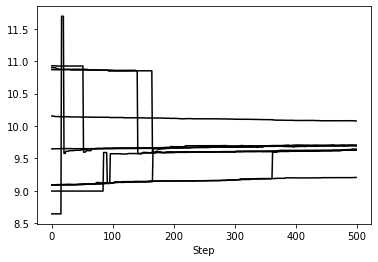

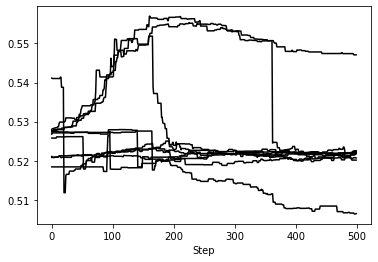

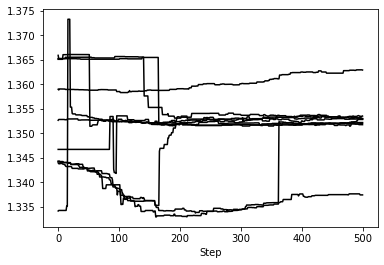

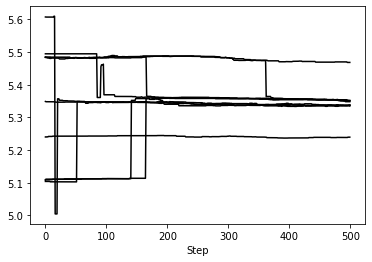

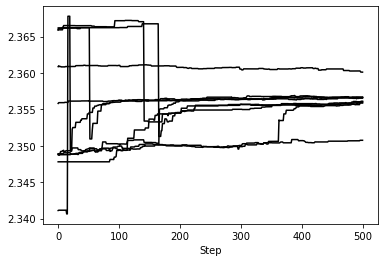

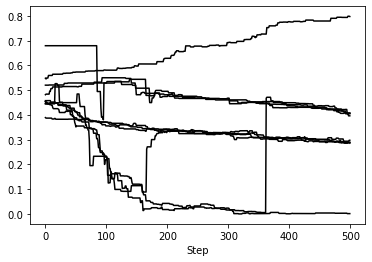

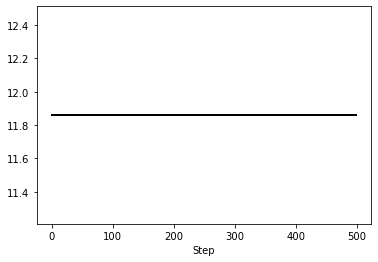

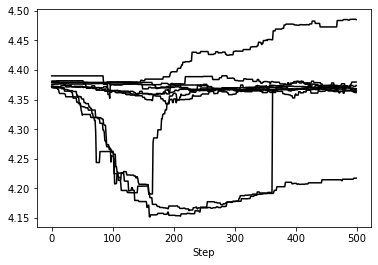

In [46]:
## example for how to look at chains:
#ecc_chains = my_driver.sampler.examine_chains(n_walkers=10)#(param_list=['ecc1'])
ecc_chains = mcmc_sampler.examine_chains(n_walkers=10)#(param_list=['ecc1'])

In [47]:
median_values.shape

(7,)

[  9.65967409   0.52196379  77.49350076 306.31869424 135.00225778
   0.36830304   4.36910116]


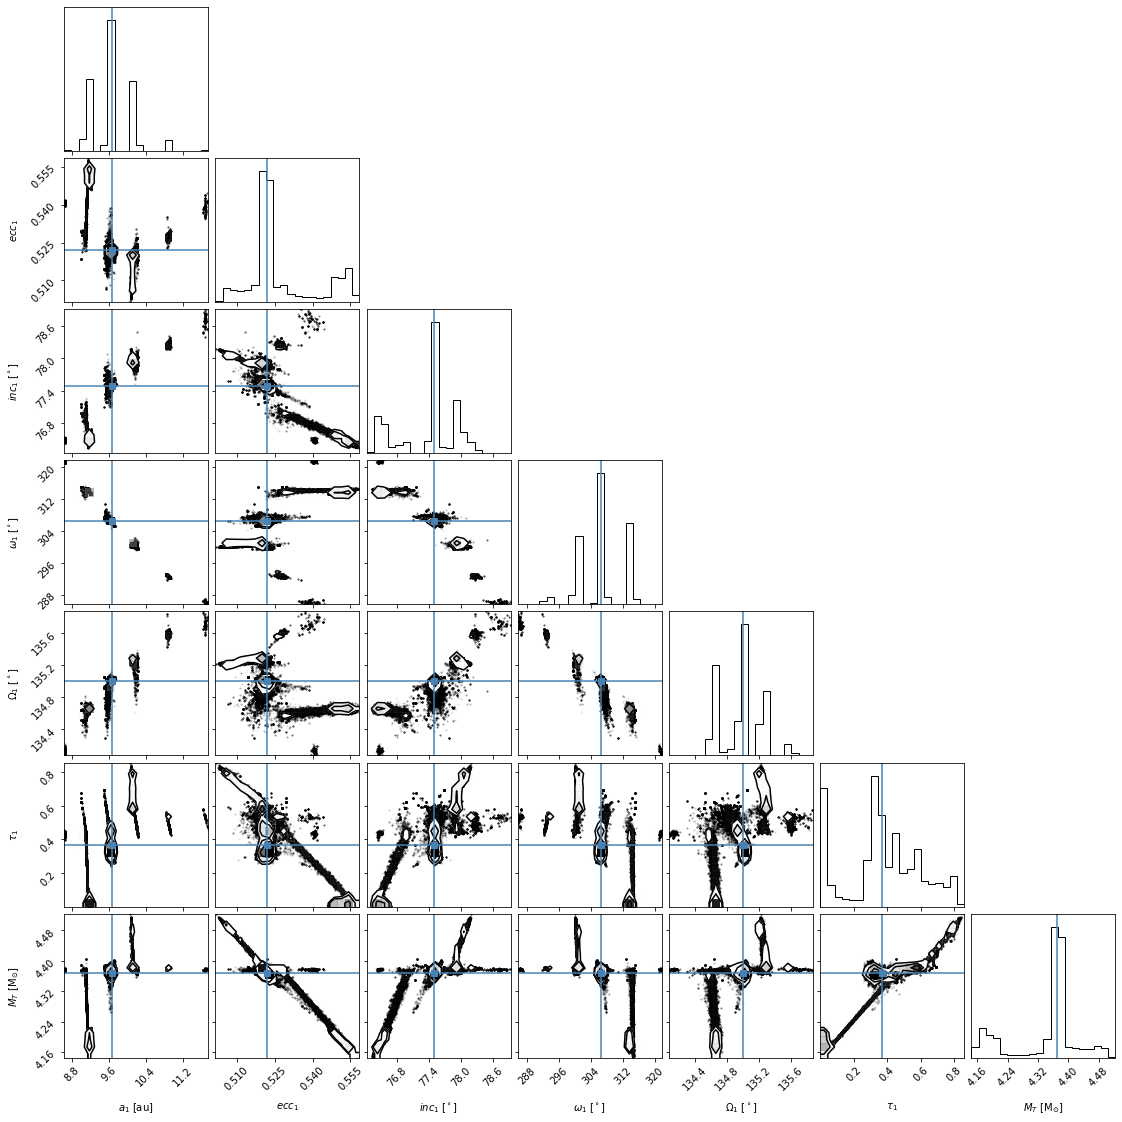

In [48]:
#corner_plot_fig = my_driver.sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'mtot']) # Creates a corner plot and returns Figure object
median_values = np.median(mcmc_sampler.results.post,axis=0) # Compute median of each parameter
#range_values = np.ones_like(median_values)*0.95 # Plot only 95% range for each parameter

median_values = np.delete(median_values,6)
#range_values = np.delete(range_values,6)

median_values[2]*=180/np.pi
median_values[3]*=180/np.pi
median_values[4]*=180/np.pi

print(median_values)

corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'mtot'],
                                                   truths=median_values)#,range=range_values)
corner_plot_fig.savefig('/Users/tgardner/ARMADA_orbits/%s_corner.png'%target) # This is matplotlib.figure.Figure.savefig()

/var/folders/jd/4t86pk8n2kz7t27v4t2z1jy407ly1g/T/ipykernel_36312/2133059450.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  orb_fig.show()


<Figure size 1008x432 with 0 Axes>

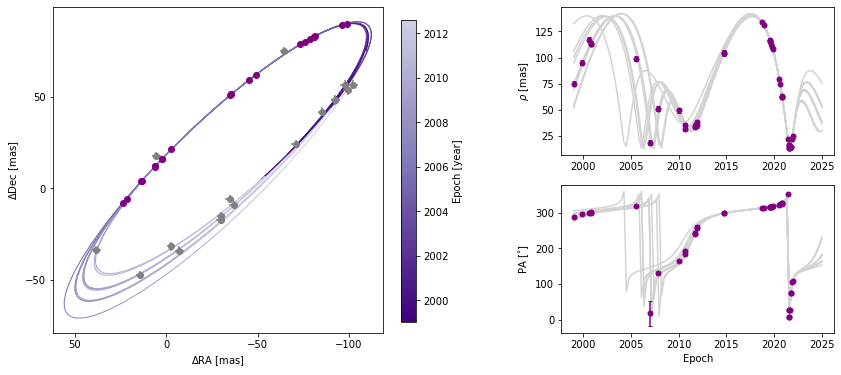

In [49]:
# plot orbits
#orb_fig = my_driver.sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=100)
orb_fig = mcmc_sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=10)


ax_orb, ax_cbar, ax_sep, ax_pa  = orb_fig.axes

data_tab = my_driver.system.data_table

epochs_yr = Time(data_tab['epoch'], format='mjd').decimalyear
epochs_armada = Time(t, format='mjd').decimalyear
epochs_wds = Time(t_wds, format='mjd').decimalyear

xdata = data_tab['quant1']; xdata_err = data_tab['quant1_err']
ydata = data_tab['quant2']; ydata_err = data_tab['quant2_err']

#### ARMADA #######
### add data to sep panel
#ax_sep.plot(
#    epochs_armada, p, '+',
#    color='purple', zorder=4)
### add data to PA panel
#ax_pa.plot(
#    epochs_armada, theta*180/np.pi, '+',
#    color='purple', zorder=4)
### add data to orbit panel
ax_orb.errorbar(
    xpos, ypos, xerr=xerr, yerr=yerr,
    color='purple', linestyle='', fmt='o', zorder=4)

##### WDS #######
### add data to sep panel
#ax_sep.plot(
#    epochs_wds, p_wds, '+',
#    color='grey', zorder=3)
### add data to PA panel
#ax_pa.plot(
#    epochs_wds, theta_wds*180/np.pi, '+',
#    color='grey', zorder=3)
### add data to orbit panel
ax_orb.errorbar(
    xpos_wds, ypos_wds, xerr=xerr_wds, yerr=yerr_wds,
    color='grey', linestyle='', fmt='o', zorder=3)

orb_fig.show()

In [50]:
median_values = np.median(mcmc_sampler.results.post,axis=0) # Compute median of each parameter
print(median_values)

period = np.sqrt(median_values[0]**3 / median_values[-1])
semi = median_values[0] * median_values[6]

print("Period = ", period)
print("a = ", semi)

[ 9.65967409  0.52196379  1.35251674  5.34626977  2.3562339   0.36830304
 11.86        4.36910116]
Period =  14.363082691891051
a =  114.56373473244061


## Include a second component!

In [ ]:
## select system parameters
num_secondary_bodies = 2
m0 = 3.7 # [Msol]
plx = 12.85 # [mas]
mass_err = 0 # [Msol]
plx_err = 0 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 1000
num_threads = mp.cpu_count() # or a different number if you prefer

In [ ]:
## modify parameters
sys = system.System(
    num_secondary_bodies, data_table, system_mass,
    plx, mass_err=mass_err, plx_err=plx_err, fit_secondary_mass=True)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

In [ ]:
## change mtot to uniform
#sys.sys_priors[lab['m0']] = priors.UniformPrior(0,10)
sys.sys_priors[lab['m1']] = priors.UniformPrior(0,10)
sys.sys_priors[lab['m2']] = priors.UniformPrior(0,10)

## limit Omega to <180deg (IF NO RV)
sys.sys_priors[lab['pan1']] = priors.UniformPrior(0,np.pi)
sys.sys_priors[lab['pan2']] = priors.UniformPrior(0,np.pi)

## I find uniform prior better for semi-major
sys.sys_priors[lab['sma1']] = priors.UniformPrior(0,50)
sys.sys_priors[lab['sma2']] = priors.UniformPrior(0,50)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

In [ ]:
## setup a run
my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads})

In [ ]:
## run the chains
total_orbits = 100000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 50 # steps to burn in per walker
thin = 2 # only save every 2nd step

#my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers, num_threads)
mcmc_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

In [ ]:
corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'm1', 'm2'])
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner_triple_star.png'%target) # This is matplotlib.figure.Figure.savefig()

In [ ]:
corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma2', 'ecc2', 'inc2', 'aop2', 'pan2','tau2', 'm1', 'm2']) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner_triple_planet.png'%target) # This is matplotlib.figure.Figure.savefig()

In [ ]:
# plot orbits
orb_fig = mcmc_sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=100, object_to_plot=1)
ax_orb, ax_cbar, ax_sep, ax_pa  = orb_fig.axes

data_tab = my_driver.system.data_table

epochs_yr = Time(data_tab['epoch'], format='mjd').decimalyear
epochs_armada = Time(t, format='mjd').decimalyear
epochs_wds = Time(t_wds, format='mjd').decimalyear

xdata = data_tab['quant1']; xdata_err = data_tab['quant1_err']
ydata = data_tab['quant2']; ydata_err = data_tab['quant2_err']

#### ARMADA #######
## add data to sep panel
ax_sep.plot(
    epochs_armada, p, '+',
    color='purple', zorder=4)
## add data to PA panel
ax_pa.plot(
    epochs_armada, theta*180/np.pi, '+',
    color='purple', zorder=4)
## add data to orbit panel
ax_orb.errorbar(
    xpos, ypos, xerr=xerr, yerr=yerr,
    color='purple', linestyle='', fmt='o', zorder=4)

##### WDS #######
## add data to sep panel
ax_sep.plot(
    epochs_wds, p_wds, '+',
    color='grey', zorder=3)
## add data to PA panel
ax_pa.plot(
    epochs_wds, theta_wds*180/np.pi, '+',
    color='grey', zorder=3)
## add data to orbit panel
ax_orb.errorbar(
    xpos_wds, ypos_wds, xerr=xerr_wds, yerr=yerr_wds,
    color='grey', linestyle='', fmt='o', zorder=3)

orb_fig.show()